<a href="https://colab.research.google.com/github/Hrushithanidikonda/oil_prices_assignment/blob/main/Oil_Price_TimeSeries_ARIMA_Prophet_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mount Drive and Import Libraries



In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")


##  2. Load and Preprocess Training Data




In [36]:
# Define the function
def load_and_preprocess_data(filepath):
    """
    Loads and preprocesses oil price data:
    - Reads CSV with 'Date' parsed
    - Sorts by 'Date'
    - Sets 'Date' as index
    - Averages duplicate dates using groupby

    Parameters:
        filepath (str): Full path to the CSV file

    Returns:
        pd.DataFrame: Preprocessed DataFrame
    """
    df = pd.read_csv(filepath, parse_dates=["Date"])
    df = df.sort_values("Date").set_index("Date")
    df = df.groupby(df.index).mean()
    return df

df = load_and_preprocess_data("/content/drive/MyDrive/oil_price.csv")


## 3. Plot Cleaned Oil Price Time Series


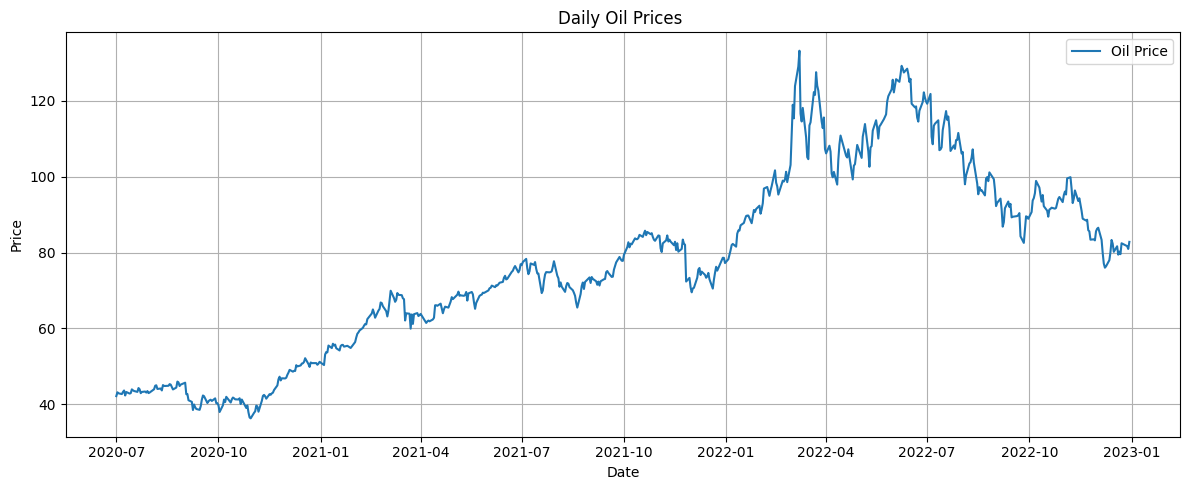

In [56]:
# Plot the original cleaned oil price time series.

def plot_oil_price_time_series(df):
    """
    Plots the original cleaned oil price time series.

    Parameters:
        df (pd.DataFrame): DataFrame containing the oil prices with DateTime index.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(df, label='Oil Price')
    plt.title('Daily Oil Prices ')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# USE the function
plot_oil_price_time_series(df)


##  4. Stationarity Check using ADF Test and Differencing


In [42]:
def run_adf_test(series, label=""):
    """
    Performs Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
        series (pd.Series): Time series data (e.g., df['Price'])
        label (str): Optional label to print for context

    Returns:
        tuple: (ADF statistic, p-value)
    """
    result = adfuller(series)
    print(f"ADF Statistic{label}:", result[0])
    print(f"p-value{label}:", result[1])
    return result[0], result[1]
def difference_series(df):
    """
    Applies first-order differencing to remove trend and returns the result.

    Parameters:
        df (pd.DataFrame): Original DataFrame with a 'Price' column

    Returns:
        pd.DataFrame: Differenced DataFrame
    """
    return df.diff().dropna()
# Run ADF test on original series
run_adf_test(df['Price'], label=" (Original)")

# First-order differencing
df_diff = difference_series(df)

# Run ADF test on differenced series
run_adf_test(df_diff['Price'], label=" (1st Diff)")


ADF Statistic (Original): -1.598608589550151
p-value (Original): 0.48429238915100054
ADF Statistic (1st Diff): -5.278578124041285
p-value (1st Diff): 6.0637563460194175e-06


(np.float64(-5.278578124041285), np.float64(6.0637563460194175e-06))

##  5. ACF and PACF Plots


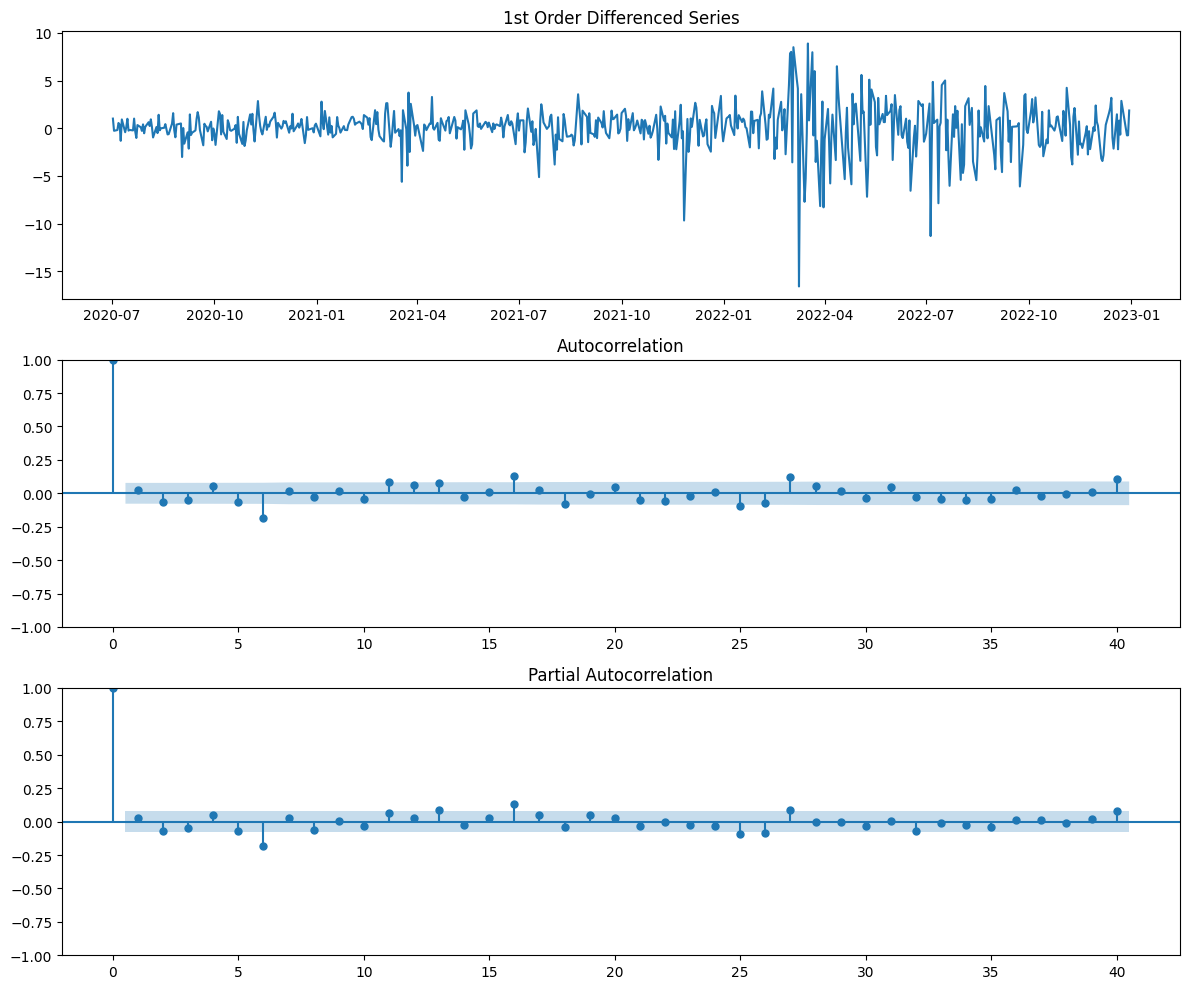

In [43]:
def plot_acf_pacf(df_diff_series, lags=40):
    """
    Plots the first-order differenced series along with its ACF and PACF.

    Parameters:
        df_diff_series (pd.Series): Differenced time series (e.g., df_diff['Price'])
        lags (int): Number of lags to display in ACF and PACF
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # Plot differenced series
    axes[0].plot(df_diff_series)
    axes[0].set_title('1st Order Differenced Series')

    # Plot ACF and PACF
    plot_acf(df_diff_series, ax=axes[1], lags=lags)
    plot_pacf(df_diff_series, ax=axes[2], lags=lags)

    plt.tight_layout()
    plt.show()

plot_acf_pacf(df_diff['Price'])



#  6. ARIMA Model Selection (Grid Search)


In [44]:
def find_best_arima_order(series, p_range=range(0, 9), d=1, q_range=range(0, 9)):
    """
    Performs a grid search to find the best (p, d, q) order for ARIMA
    by minimizing the AIC (Akaike Information Criterion).

    Parameters:
        series (pd.Series): Time series data to fit
        p_range (range): Range of p values (AR order)
        d (int): Differencing order
        q_range (range): Range of q values (MA order)

    Returns:
        tuple: Best (p, d, q) order and its corresponding AIC
    """
    pdq = list(itertools.product(p_range, [d], q_range))
    best_aic = np.inf
    best_order = None

    for order in pdq:
        try:
            model = ARIMA(series, order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
        except:
            continue

    print("Best ARIMA order:", best_order)
    print("Best AIC:", best_aic)
    return best_order, best_aic

best_order, best_aic = find_best_arima_order(df['Price'])


Best ARIMA order: (6, 1, 7)
Best AIC: 2808.3818624022247


## 7. Fit ARIMA Model and Generate Forecast


In [45]:
def fit_arima_and_forecast(series, order, forecast_steps=730):
    """
    Fits an ARIMA model and generates forecasts with confidence intervals.

    Parameters:
        series (pd.Series): Time series data (e.g., df['Price'])
        order (tuple): ARIMA (p,d,q) order
        forecast_steps (int): Number of future time steps (e.g., 730 for 2 years)

    Returns:
        forecast_mean (pd.Series): Forecast values indexed by future dates
        forecast_ci (pd.DataFrame): Confidence intervals
        lower_bound (np.ndarray): Lower CI for plotting
        upper_bound (np.ndarray): Upper CI for plotting
    """
    final_model = ARIMA(series, order=order)
    final_result = final_model.fit()

    forecast = final_result.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1),
                                   periods=forecast_steps, freq='D')
    forecast_mean.index = forecast_index
    forecast_ci.index = forecast_index

    lower_bound = forecast_ci.iloc[:, 0].values.astype(float)
    upper_bound = forecast_ci.iloc[:, 1].values.astype(float)

    return forecast_mean, forecast_ci, lower_bound, upper_bound

forecast_mean, forecast_ci, lower_bound, upper_bound = fit_arima_and_forecast(
    df['Price'], best_order, forecast_steps=730
)


##  8. Plot ARIMA Forecast


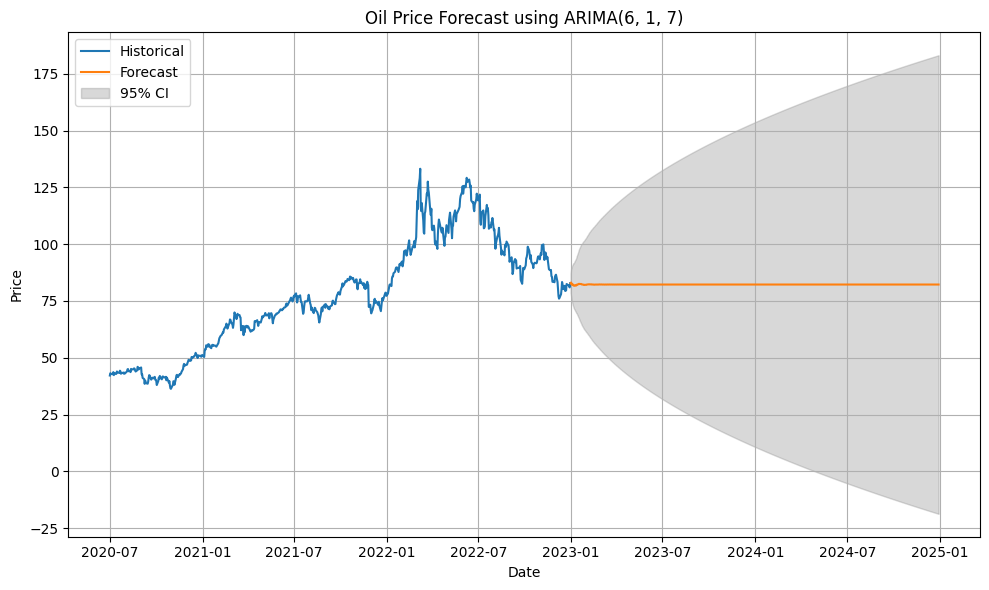

In [46]:
def plot_arima_forecast(df, forecast_mean, lower_bound, upper_bound, best_order):
    """
    Plots ARIMA forecast results with 95% confidence interval.

    Parameters:
        df (pd.DataFrame): Original time series DataFrame with Date index and 'Price' column
        forecast_mean (pd.Series): Forecasted values with future datetime index
        lower_bound (np.ndarray): Lower confidence interval bound
        upper_bound (np.ndarray): Upper confidence interval bound
        best_order (tuple): ARIMA (p,d,q) model order used
    """
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Price'], label='Historical')
    plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast')
    plt.fill_between(forecast_mean.index, lower_bound, upper_bound,
                     color='gray', alpha=0.3, label='95% CI')
    plt.title(f'Oil Price Forecast using ARIMA{best_order}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_arima_forecast(df, forecast_mean, lower_bound, upper_bound, best_order)


##  9. In-Sample RMSE Evaluation (ARIMA)


In [47]:
def calculate_in_sample_rmse(model_result, original_series):
    """
    Calculates the in-sample RMSE for a fitted ARIMA model.

    Parameters:
        model_result: Fitted ARIMA model result (e.g., from model.fit())
        original_series (pd.Series): The original time series used for training

    Returns:
        float: RMSE value
    """
    # Predict in-sample values starting from index 1
    pred_in_sample = model_result.predict(start=1, end=len(original_series)-1, typ="levels")

    # Calculate RMSE between actual and predicted
    rmse = np.sqrt(mean_squared_error(original_series[1:], pred_in_sample))
    print("In-sample RMSE:", rmse)
    return rmse

rmse_insample = calculate_in_sample_rmse(final_result, df['Price'])


In-sample RMSE: 2.1664549888163123


##  10. Load and Preprocess Actual Oil Price Data (2023–2025)


In [48]:
def load_actual_oil_data(filepath, start_date='2023-01-01'):
    """
    Loads and preprocesses actual oil price data for evaluation.

    Parameters:
        filepath (str): Path to the actual data CSV file
        start_date (str): Date from which to retain actuals (e.g., '2023-01-01')

    Returns:
        pd.DataFrame: Cleaned DataFrame with daily frequency and forward-filled values
    """
    actual_df = pd.read_csv(filepath, skiprows=4)
    actual_df.columns = ['Date', 'Price']
    actual_df['Date'] = pd.to_datetime(actual_df['Date'], format='%b %d, %Y')
    actual_df = actual_df.set_index('Date').sort_index()

    # Clean and filter data
    actual_df = actual_df[actual_df.index.notna()]
    actual_df = actual_df.loc[start_date:]
    actual_df = actual_df.asfreq('D').fillna(method='ffill')

    return actual_df

actual_df = load_actual_oil_data("/content/drive/MyDrive/RBRTEd.csv")


##  11. Plot ARIMA Forecast vs Actual Oil Prices


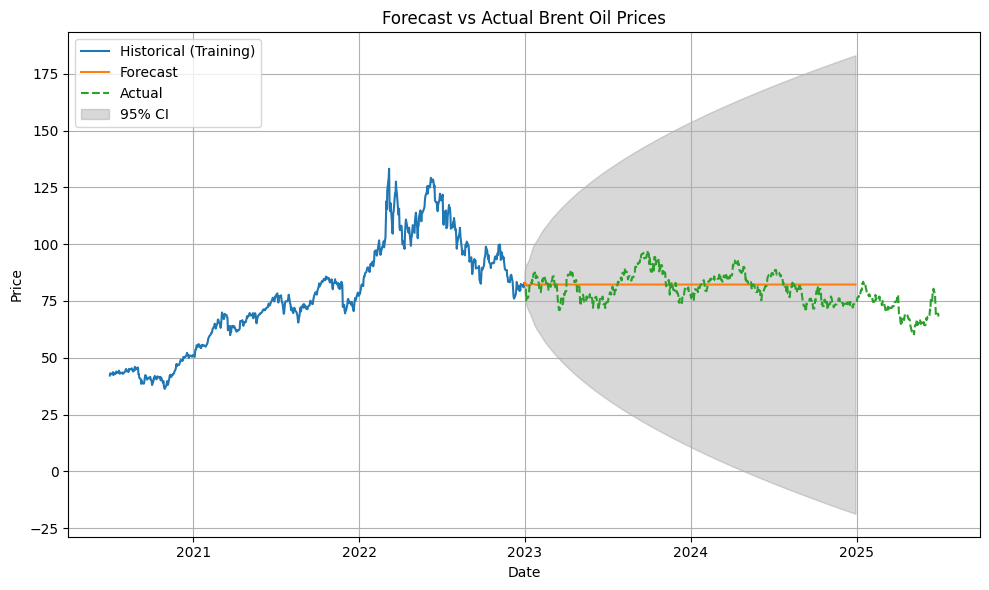

In [49]:
def plot_forecast_vs_actual(df, forecast_mean, actual_df, lower_bound, upper_bound):
    """
    Plots the ARIMA forecast against actual oil prices with confidence intervals.

    Parameters:
        df (pd.DataFrame): Original training data with DateTime index and 'Price'
        forecast_mean (pd.Series): Forecasted values (with datetime index)
        actual_df (pd.DataFrame): Actual oil prices (with datetime index and 'Price')
        lower_bound (np.ndarray): Lower confidence interval for forecast
        upper_bound (np.ndarray): Upper confidence interval for forecast
    """
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Price'], label='Historical (Training)')
    plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
    plt.plot(actual_df.index, actual_df['Price'], label='Actual', linestyle='--')
    plt.fill_between(forecast_mean.index, lower_bound, upper_bound,
                     color='gray', alpha=0.3, label='95% CI')
    plt.title('Forecast vs Actual Brent Oil Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_forecast_vs_actual(df, forecast_mean, actual_df, lower_bound, upper_bound)


##  12. Evaluate Forecast Accuracy (ARIMA vs Actual)


In [50]:
def compare_forecast_to_actual(forecast_series, actual_df, label="Forecast vs Actual"):
    """
    Compares forecasted values to actual observed values by calculating RMSE.

    Parameters:
        forecast_series (pd.Series): Forecasted time series with datetime index
        actual_df (pd.DataFrame): Actual observed values with 'Price' column and datetime index
        label (str): Optional label to print with the RMSE result

    Returns:
        float: Root Mean Squared Error (RMSE)
    """
    common_idx = forecast_series.index.intersection(actual_df.index)
    rmse = np.sqrt(mean_squared_error(actual_df.loc[common_idx, 'Price'], forecast_series.loc[common_idx]))
    print(f"{label} RMSE:", rmse)
    return rmse

compare_forecast_to_actual(forecast_mean, actual_df)

Forecast vs Actual RMSE: 5.892843710102318


np.float64(5.892843710102318)

##  13. Fit Prophet Model to Oil Price Data


In [51]:
def prepare_and_fit_prophet(df):
    """
    Prepares data and fits a Prophet model with daily seasonality.

    Parameters:
        df (pd.DataFrame): Original time series DataFrame with datetime index and 'Price' column

    Returns:
        Prophet: Fitted Prophet model
        pd.DataFrame: DataFrame formatted for Prophet with 'ds' and 'y' columns
    """
    prophet_df = df.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)
    return model, prophet_df

prophet_model, prophet_df = prepare_and_fit_prophet(df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp624c3g6x/q2773x4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp624c3g6x/vi44srxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73785', 'data', 'file=/tmp/tmp624c3g6x/q2773x4_.json', 'init=/tmp/tmp624c3g6x/vi44srxu.json', 'output', 'file=/tmp/tmp624c3g6x/prophet_modelwihn_l5u/prophet_model-20250707025832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:58:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##  14. Forecast Future Prices using Prophet


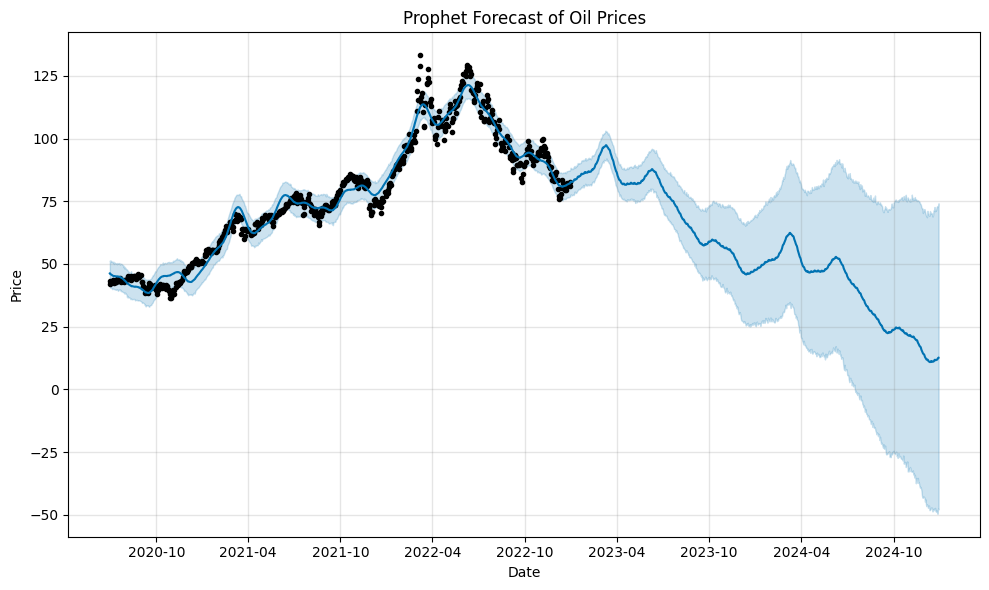

In [52]:
def forecast_and_plot_prophet(model, periods=730):
    """
    Generates future forecast using a fitted Prophet model and plots the result.

    Parameters:
        model (Prophet): Fitted Prophet model
        periods (int): Number of days into the future to forecast

    Returns:
        pd.DataFrame: Forecast DataFrame from Prophet
    """
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Plot forecast
    model.plot(forecast)
    plt.title('Prophet Forecast of Oil Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return forecast

forecast = forecast_and_plot_prophet(prophet_model, periods=730)


##  15. Prophet Model Components Plot


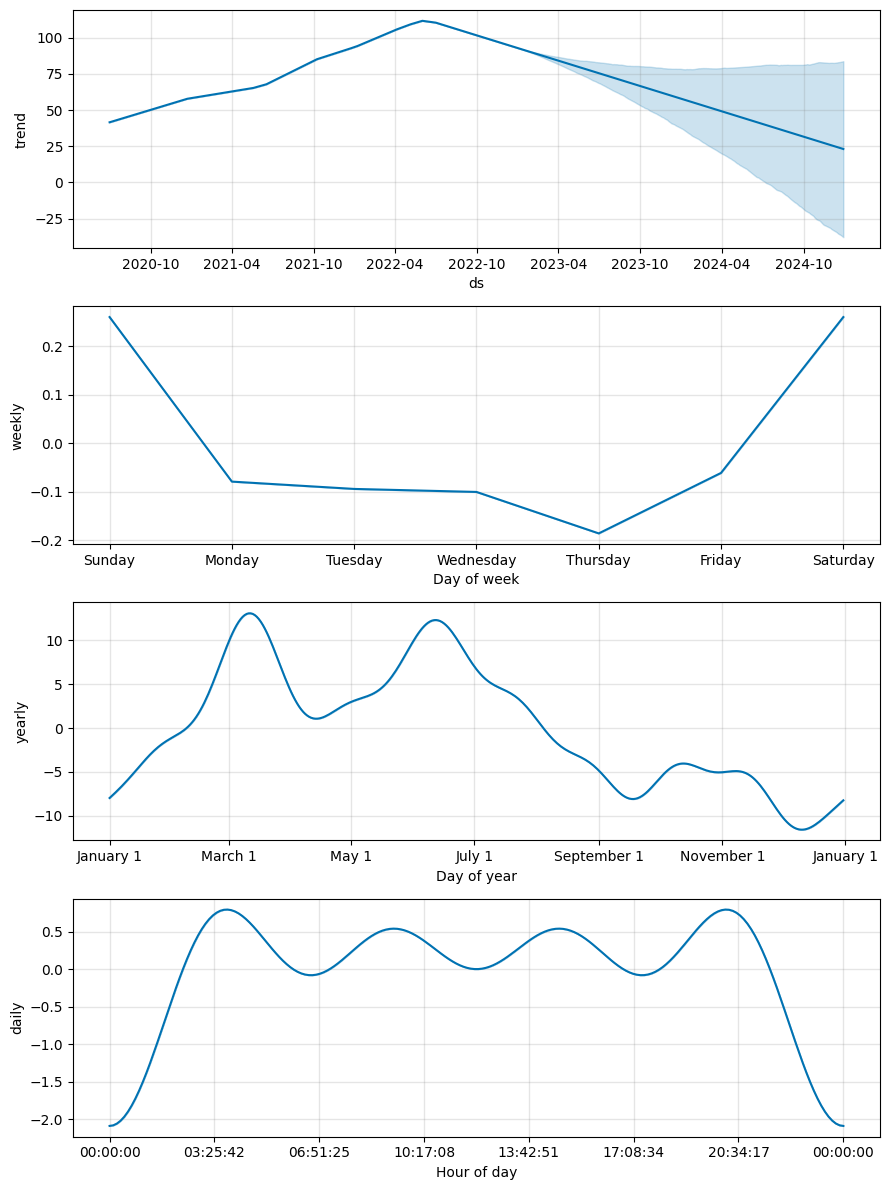

In [53]:
def plot_prophet_components(model, forecast):
    """
    Plots the trend, weekly, and yearly components from a Prophet forecast.

    Parameters:
        model (Prophet): Fitted Prophet model
        forecast (pd.DataFrame): Forecast output from Prophet
    """
    model.plot_components(forecast)
    plt.tight_layout()
    plt.show()


plot_prophet_components(prophet_model, forecast)


##  16. In-Sample RMSE Evaluation (Prophet)


In [54]:
def evaluate_prophet_in_sample_rmse(df, forecast):
    """
    Calculates the in-sample RMSE of the Prophet forecast against the training data.

    Parameters:
        df (pd.DataFrame): Original training data with DateTime index and 'Price' column
        forecast (pd.DataFrame): Prophet forecast DataFrame (must include 'ds' and 'yhat')

    Returns:
        float: In-sample RMSE
    """
    forecast_in_sample = forecast.set_index('ds').loc[df.index]
    rmse = np.sqrt(mean_squared_error(df['Price'], forecast_in_sample['yhat']))
    print("Prophet In-Sample RMSE:", rmse)
    return rmse

evaluate_prophet_in_sample_rmse(df, forecast)

Prophet In-Sample RMSE: 4.068854195832248


np.float64(4.068854195832248)

##  17. Prophet Forecast vs Actual Oil Prices


Prophet Forecast vs Actual RMSE: 34.231103189024964


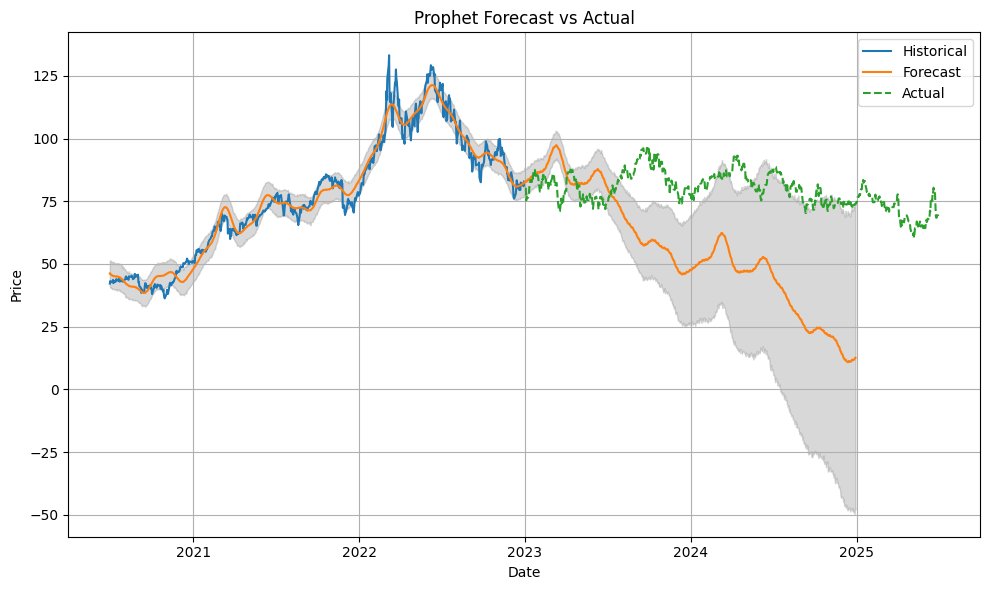

In [55]:
def evaluate_prophet_forecast_vs_actual(forecast, actual_df, label="Prophet Forecast vs Actual"):
    """
    Evaluates Prophet forecast against actual observed values using RMSE.

    Parameters:
        forecast (pd.DataFrame): Prophet forecast with 'ds', 'yhat'
        actual_df (pd.DataFrame): Actual data with datetime index and 'Price'

    Returns:
        float: RMSE value
    """
    forecast = forecast.set_index('ds')
    common_idx = forecast.index.intersection(actual_df.index)
    rmse = np.sqrt(mean_squared_error(actual_df.loc[common_idx, 'Price'], forecast.loc[common_idx, 'yhat']))
    print(f"{label} RMSE:", rmse)
    return rmse, forecast
def plot_prophet_forecast_vs_actual(df, forecast_df, actual_df):
    """
    Plots Prophet forecast with confidence intervals alongside actual and historical prices.

    Parameters:
        df (pd.DataFrame): Original training data
        forecast_df (pd.DataFrame): Prophet forecast with 'yhat', 'yhat_lower', 'yhat_upper'
        actual_df (pd.DataFrame): Actual observed values
    """
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Price'], label='Historical')
    plt.plot(forecast_df.index, forecast_df['yhat'], label='Forecast')
    plt.plot(actual_df.index, actual_df['Price'], label='Actual', linestyle='--')
    plt.fill_between(forecast_df.index, forecast_df['yhat_lower'], forecast_df['yhat_upper'],
                     color='gray', alpha=0.3)
    plt.title('Prophet Forecast vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

rmse_prophet_actual, forecast_future = evaluate_prophet_forecast_vs_actual(forecast, actual_df)
plot_prophet_forecast_vs_actual(df, forecast_future, actual_df)
